In [2]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve, auc

# Chicago Car Crash Analysis

## Overview 
add overview 

## Business Problem

add buisness problem

## Data Source 

Car crash and vehicle accident data was sourced from the [Chicago Data Portal](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d/about_data). It originates from the [City of Chicago](http://www.chicago.gov/)

Data collection began in 2015, but was only adopted by all police departments in 2017. The most recent data entry was from September 26, 2024. 

## Results

add results

# Data Import and Cleaning 

In [2]:
df_vehicles = pd.read_csv("data/Traffic_Crashes_Vehicles.csv")
df_people = pd.read_csv("data/Traffic_Crashes_People.csv")
df_crashes = pd.read_csv("data/Traffic_Crashes_Crashes.csv")

/var/folders/4f/cr2zm2px70q9hrgj23zmw7_r0000gn/T/ipykernel_27524/3674209955.py:1: DtypeWarning: Columns (20,39,40,41,43,47,48,49,52,54,57,58,60,70) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vehicles = pd.read_csv("data/Traffic_Crashes_Vehicles.csv")
/var/folders/4f/cr2zm2px70q9hrgj23zmw7_r0000gn/T/ipykernel_27524/3674209955.py:2: DtypeWarning: Columns (19,23,24,25,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_people = pd.read_csv("data/Traffic_Crashes_People.csv")


## Merge Dataframes

First we sample 300,000 crash reports, then we merge the vehicle and people involved. 

In [3]:
#Random sample of vehicles 
df_accidents = df_vehicles.sample(n=300000, random_state=42)

In [4]:
df_accidents.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 358790 to 1361083
Data columns (total 71 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   CRASH_UNIT_ID             300000 non-null  int64  
 1   CRASH_RECORD_ID           300000 non-null  object 
 2   CRASH_DATE                300000 non-null  object 
 3   UNIT_NO                   300000 non-null  int64  
 4   UNIT_TYPE                 299589 non-null  object 
 5   NUM_PASSENGERS            44775 non-null   float64
 6   VEHICLE_ID                292985 non-null  float64
 7   CMRC_VEH_I                5563 non-null    object 
 8   MAKE                      292984 non-null  object 
 9   MODEL                     292960 non-null  object 
 10  LIC_PLATE_STATE           266235 non-null  object 
 11  VEHICLE_YEAR              246257 non-null  float64
 12  VEHICLE_DEFECT            292985 non-null  object 
 13  VEHICLE_TYPE              292985 non-null  

In [5]:
#Then we can add the crash report data 
df_accidents = df_accidents.merge(df_crashes, how="inner", on=["CRASH_RECORD_ID", "CRASH_DATE"])

In [6]:
df_accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299970 entries, 0 to 299969
Columns: 117 entries, CRASH_UNIT_ID to LOCATION
dtypes: float64(20), int64(8), object(89)
memory usage: 267.8+ MB


In [7]:
#every person and vehicle should have a match for the record ID, vehicle ID, and crash date
#This makes the dataframe larger as multiple people are involved in each accident 
df_accidents = df_accidents.merge(df_people, how="inner", on=["CRASH_RECORD_ID", "VEHICLE_ID", "CRASH_DATE"])

In [8]:
df_accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324360 entries, 0 to 324359
Columns: 143 entries, CRASH_UNIT_ID to CELL_PHONE_USE
dtypes: float64(23), int64(8), object(112)
memory usage: 353.9+ MB


The dataframe gets larger when merging in the people, as there are sometimes more than one person involved in an accident.  

# THIS IS FOR WORKING PURPOSES. 

# USE THIS TO IMPORT DF WITHOUT RUNNING THE CELLS ABOVE.

## Export Final

In [13]:
df_accidents.to_csv('data/Final_Data.csv')

## Read Final

In [37]:
df_accidents = pd.read_csv("data/Final_Data.csv")

/var/folders/4f/cr2zm2px70q9hrgj23zmw7_r0000gn/T/ipykernel_32274/2274169522.py:1: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,55,58,59,61,71,102,123,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accidents = pd.read_csv("data/Final_Data.csv")


# ^^^^^ DELETE BEFORE SUBMISSION

In [29]:
count = 0
for column in df_accidents.iloc[0]:
    print(df_accidents.columns[count], ":", column, ",", df_accidents.iloc[1].iloc[count])
    count += 1

Unnamed: 0 : 0 , 1
CRASH_UNIT_ID : 1344100 , 748747
CRASH_RECORD_ID : 3d1a5bb0d4c56b1671566a15ce7181e94da4ab874764fe39bd113d58f4d0a1592d290ef57916d1c02979aedcce013a08db670d24550a60639ee0ed232c6da4d5 , b1cee0206d4a3d17e14599074fe0d01f73c16f4fdfa5592f3d966669d12e5d5b7f49f122b2a695c657ee67a29006ac21da78f4567ac9801f1d196a4958a8ca00
CRASH_DATE : 05/24/2022 08:23:00 PM , 09/28/2019 01:45:00 PM
UNIT_NO : 1 , 2
UNIT_TYPE : DRIVER , DRIVER
NUM_PASSENGERS : nan , nan
VEHICLE_ID : 1276996.0 , 711349.0
CMRC_VEH_I : nan , nan
MAKE : TOYOTA , VOLKSWAGEN
MODEL : CAMRY , JETTA
LIC_PLATE_STATE : IL , IL
VEHICLE_YEAR : 2018.0 , 2012.0
VEHICLE_DEFECT : UNKNOWN , UNKNOWN
VEHICLE_TYPE : PASSENGER , PASSENGER
VEHICLE_USE : PERSONAL , PERSONAL
TRAVEL_DIRECTION : W , S
MANEUVER : TURNING LEFT , STRAIGHT AHEAD
TOWED_I : nan , nan
FIRE_I : nan , nan
OCCUPANT_CNT : 1.0 , 1.0
EXCEED_SPEED_LIMIT_I : nan , nan
TOWED_BY : nan , nan
TOWED_TO : nan , nan
AREA_00_I : Y , nan
AREA_01_I : nan , nan
AREA_02_I : nan , nan


For Group Project: Create CSVs of the truncated csvs

## Drop Unnessisary Columns

In [43]:
#remove columns with less than 50% of data present 
df_accidents.dropna(axis=1, thresh = int(0.5*df_accidents.shape[0]), inplace=True)

,Unnamed: 0,CRASH_UNIT_ID,CRASH_RECORD_ID,CRASH_DATE,UNIT_NO,UNIT_TYPE,VEHICLE_ID,MAKE,MODEL,LIC_PLATE_STATE,...,AGE,DRIVERS_LICENSE_STATE,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,BAC_RESULT
0,0,1344100,3d1a5bb0d4c56b1671566a15ce7181e94da4ab874764fe...,05/24/2022 08:23:00 PM,1,DRIVER,1276996.0,TOYOTA,CAMRY,IL,...,40.0,IL,USAGE UNKNOWN,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,UNKNOWN,UNKNOWN,NORMAL,TEST NOT OFFERED
1,1,748747,b1cee0206d4a3d17e14599074fe0d01f73c16f4fdfa559...,09/28/2019 01:45:00 PM,2,DRIVER,711349.0,VOLKSWAGEN,JETTA,IL,...,23.0,IL,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,UNKNOWN,NOT OBSCURED,NORMAL,TEST NOT OFFERED
2,2,1304152,62a78b0281ac282ceb89d3132ac5ba7e5e3ccb3bac5347...,03/24/2022 05:29:00 AM,3,DRIVER,1238532.0,GREAT DANE TRAILERS INC.,GREAT DANE TRAILERS INC.,MI,...,37.0,MI,USAGE UNKNOWN,NOT APPLICABLE,NONE,NO INDICATION OF INJURY,NONE,NOT OBSCURED,NORMAL,TEST NOT OFFERED
3,3,510444,d6ff5e6a5d94ab5e99ad3fbf64487cb06973ca089279da...,10/29/2018 08:43:00 AM,1,DRIVER,487775.0,HONDA,ACCORD,NaN,...,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,IMPROPER LANE CHANGE,UNKNOWN,UNKNOWN,TEST NOT OFFERED
4,4,1397785,9a2dce49739ffd63f3ea7d5bef721812eb7c2cb231c1b0...,08/12/2022 08:25:00 PM,3,DRIVER,1328219.0,MERCEDES-BENZ,OTHER (EXPLAIN IN NARRATIVE),IL,...,43.0,IL,USAGE UNKNOWN,NOT APPLICABLE,NONE,NO INDICATION OF INJURY,NONE,UNKNOWN,UNKNOWN,TEST NOT OFFERED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324355,324355,981844,856a1c0b8f4cb6b11d5f2fbd17caff3be1b539b3ff9bd0...,10/23/2020 11:38:00 AM,2,DRIVER,930909.0,FORD,TRANSIT CONNECT,IL,...,53.0,IL,SAFETY BELT USED,NOT APPLICABLE,NONE,NO INDICATION OF INJURY,NONE,NOT OBSCURED,NORMAL,TEST NOT OFFERED
324356,324356,627295,98892cddfb51fd9bbf244f8c00f39dd5e72fdb6e141341...,04/17/2019 04:14:00 PM,1,DRIVER,597536.0,FORD,Explorer,IL,...,23.0,NaN,USAGE UNKNOWN,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,NaN
324357,324357,627295,98892cddfb51fd9bbf244f8c00f39dd5e72fdb6e141341...,04/17/2019 04:14:00 PM,1,DRIVER,597536.0,FORD,Explorer,IL,...,21.0,NaN,USAGE UNKNOWN,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,NaN
324358,324358,627295,98892cddfb51fd9bbf244f8c00f39dd5e72fdb6e141341...,04/17/2019 04:14:00 PM,1,DRIVER,597536.0,FORD,Explorer,IL,...,52.0,IL,USAGE UNKNOWN,NOT APPLICABLE,NONE,NO INDICATION OF INJURY,FOLLOWED TOO CLOSELY,NOT OBSCURED,NORMAL,TEST REFUSED


In [44]:
df_accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324360 entries, 0 to 324359
Data columns (total 69 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     324360 non-null  int64  
 1   CRASH_UNIT_ID                  324360 non-null  int64  
 2   CRASH_RECORD_ID                324360 non-null  object 
 3   CRASH_DATE                     324360 non-null  object 
 4   UNIT_NO                        324360 non-null  int64  
 5   UNIT_TYPE                      324334 non-null  object 
 6   VEHICLE_ID                     317108 non-null  float64
 7   MAKE                           317107 non-null  object 
 8   MODEL                          317080 non-null  object 
 9   LIC_PLATE_STATE                290181 non-null  object 
 10  VEHICLE_YEAR                   268968 non-null  float64
 11  VEHICLE_DEFECT                 317108 non-null  object 
 12  VEHICLE_TYPE                  

In [47]:
matrix = df_accidents.corr(numeric_only=True)
print(matrix)

                               Unnamed: 0  CRASH_UNIT_ID   UNIT_NO  \
Unnamed: 0                       1.000000      -0.004996 -0.000147   
CRASH_UNIT_ID                   -0.004996       1.000000  0.003759   
UNIT_NO                         -0.000147       0.003759  1.000000   
VEHICLE_ID                      -0.005002       0.999986  0.001282   
VEHICLE_YEAR                     0.000440       0.007202 -0.007320   
OCCUPANT_CNT                     0.005952      -0.014034  0.103042   
POSTED_SPEED_LIMIT               0.001071       0.026549  0.073894   
STREET_NO                        0.000219       0.025113 -0.009512   
BEAT_OF_OCCURRENCE              -0.001877       0.004779 -0.007031   
NUM_UNITS                        0.000013       0.018841  0.276457   
INJURIES_TOTAL                  -0.004392       0.055309  0.112213   
INJURIES_FATAL                  -0.005684       0.009241  0.011312   
INJURIES_INCAPACITATING         -0.003736       0.010131  0.048042   
INJURIES_NON_INCAPAC

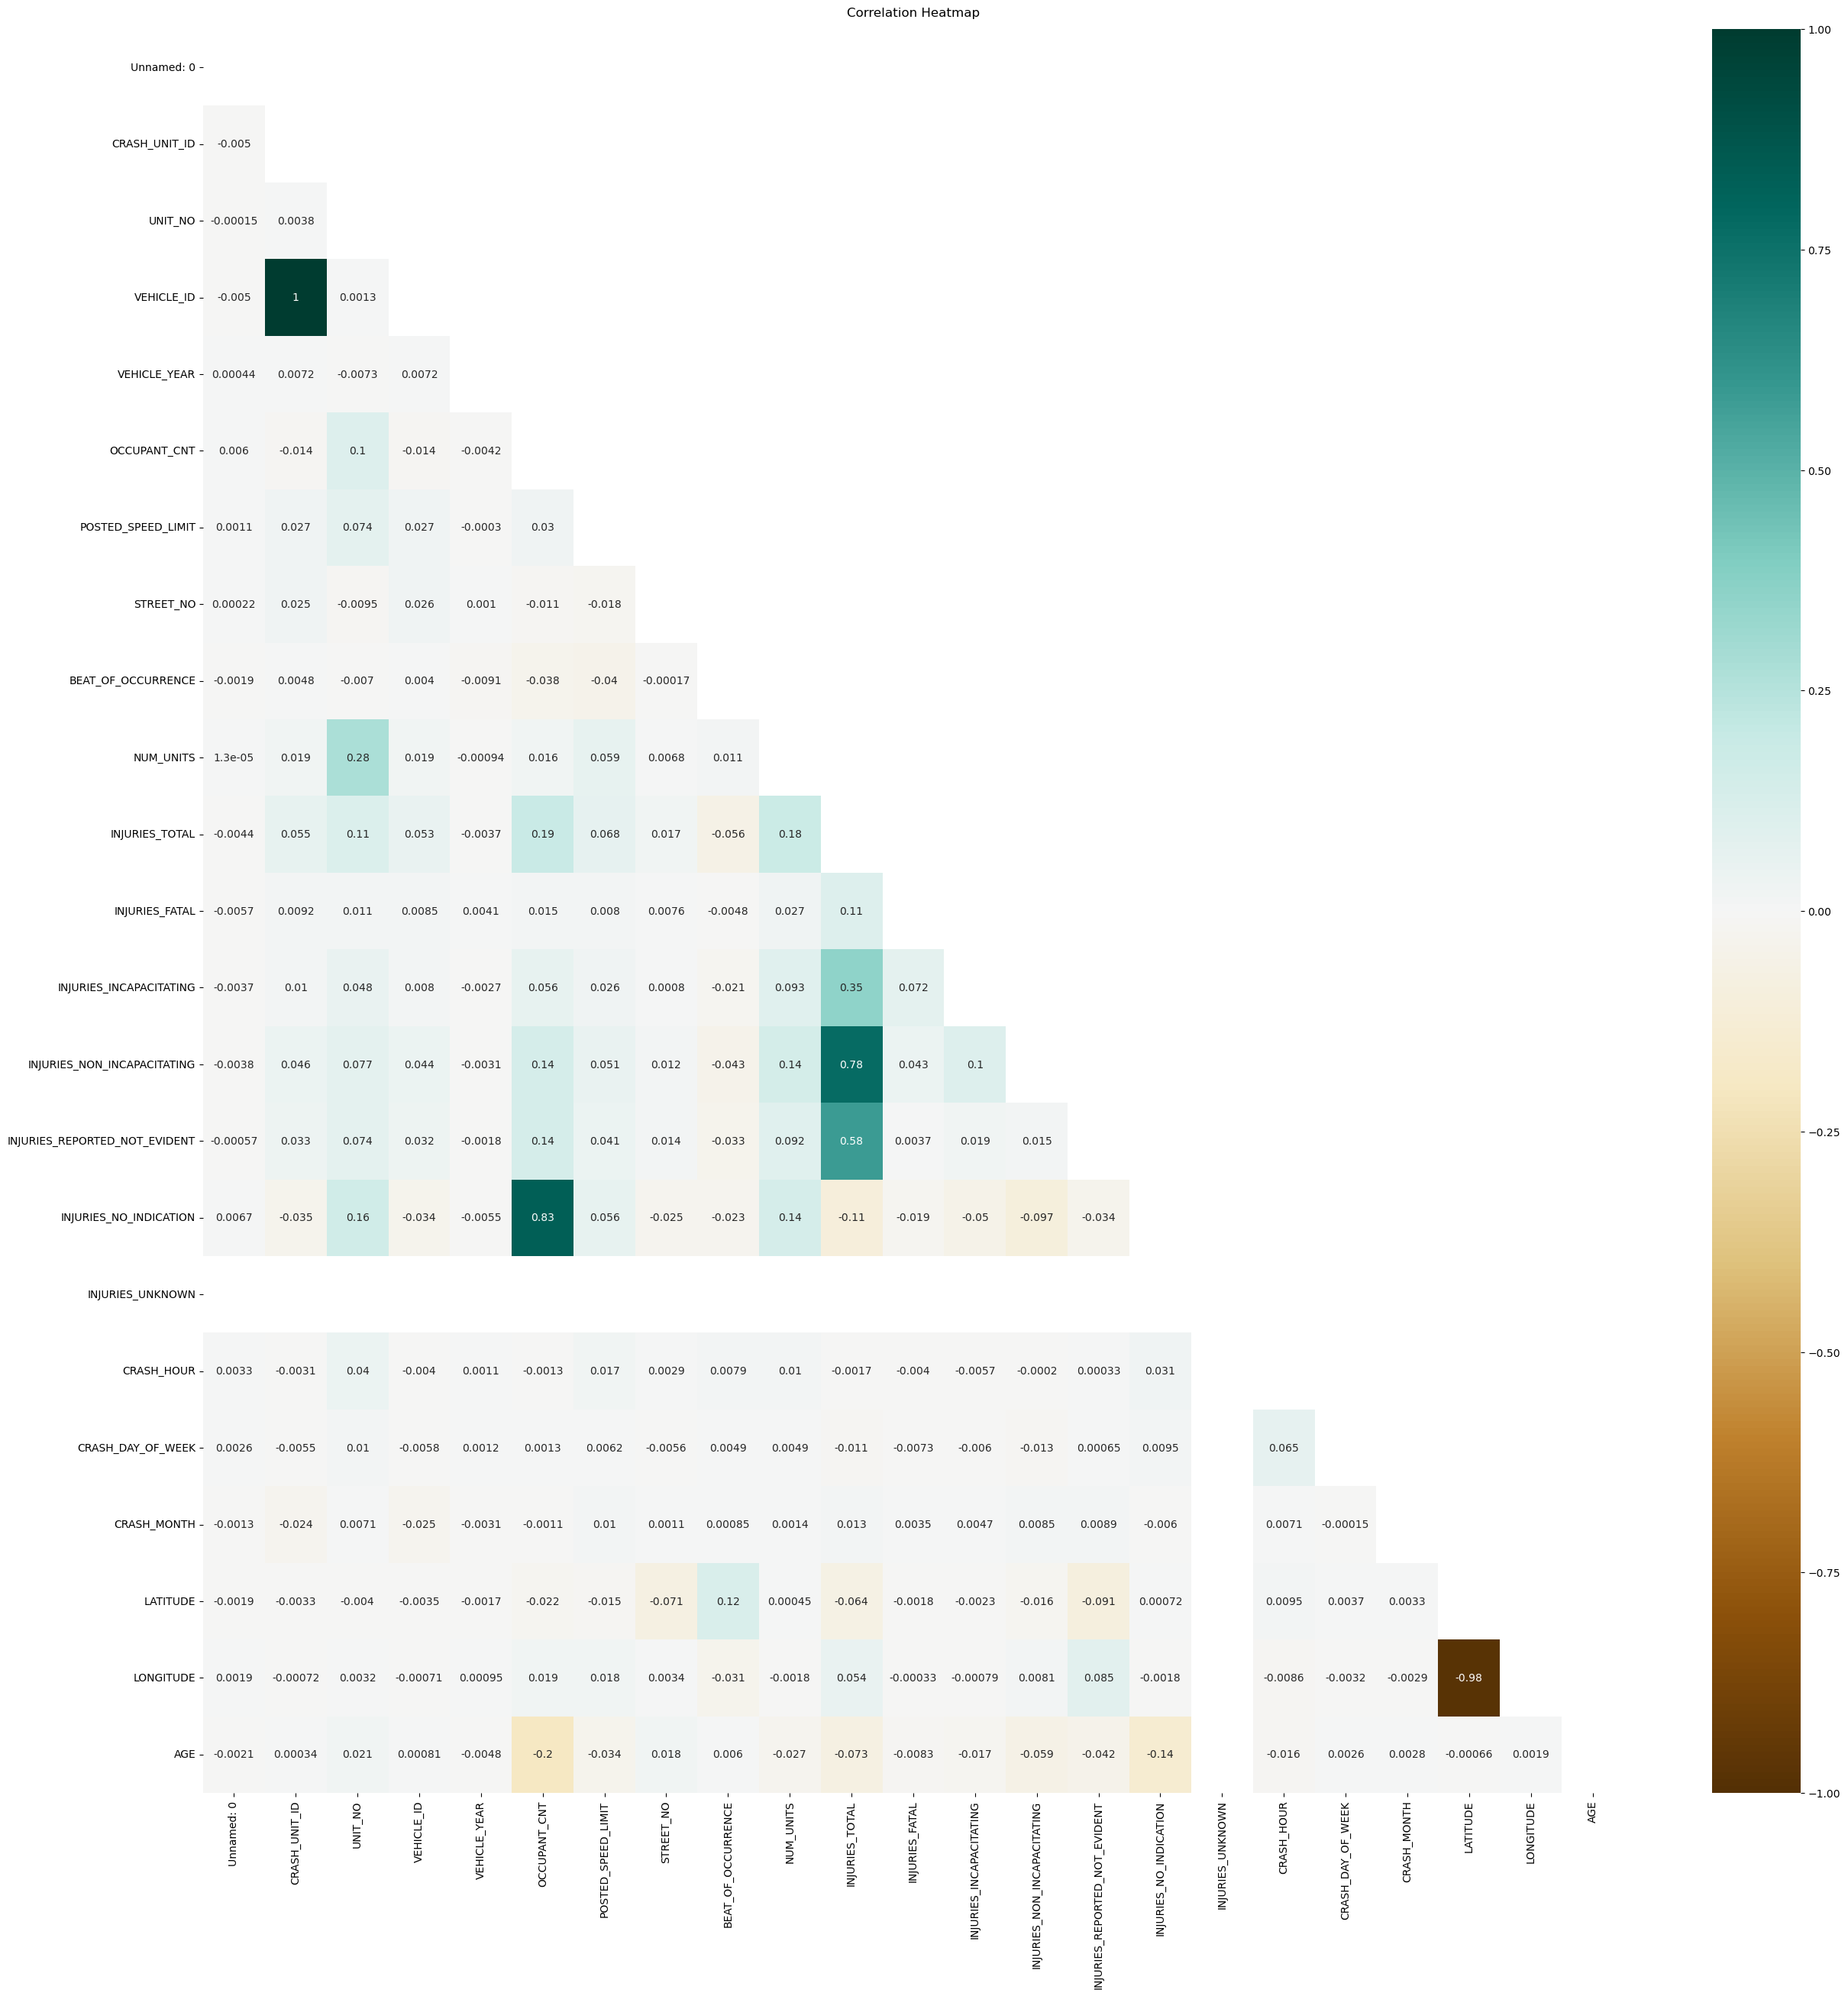

In [51]:
plt.figure(figsize=(30, 30))

#create a mask to remove the duplicate upper half
mask = np.triu(np.ones_like(matrix, dtype=np.bool))

heatmap = sns.heatmap(matrix, vmin=-1, mask=mask, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Use a Decsicion Tree model to determine importaint categories. 

### DT

# EDA

figures?

## Combine Columns into Categories 

In [17]:
#py

## Train Test Split

# Model 1

Justification of Model 1

Conclusions from model 1.

# Model 2

Justification of Model 2

Conclusions from model 1.

# Conclusions 

# Next Steps